# CSE527 Homework 6
**Due date: 23:59 on Dec. 5, 2019 (Thursday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
In this homework we are going to work on estimating the 3D pose of a person given their 2D
pose. Turns out, just regressing the 3D pose coordinates using the 2D pose works pretty well [1]
(you can find the paper [here](https://arxiv.org/pdf/1705.03098.pdf)). In Part One, we are going to work on reproducing the results of the
paper, in Part Two, we are going to try to find a way to handle noisy measurement.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

## Benchmark
Train for a least 30 epochs to get a least 44mm avg error. The test result(mm error) should be in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

## Problem 1:
{60 points} Let us first start by trying to reproduce the testing accuracy obtained by in the [paper]((https://arxiv.org/pdf/1705.03098.pdf) above using
PyTorch. The 2D pose of a person is represented as a set of 2D coordinates for each of their $n = 32$ joints
i.e $P^{2D}_{i }$= {$(x^{1}_{i}, y^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i})$}, where $(x^{j}_{i}, y^{j}_{i})$ are the 2D coordinates of the $j$’th joint of the i’th sample. Similarly, the 3D pose of a person is 
$P^{3D}_{i}$ = {$(x^{1}_{i}, y^{1}_{i}, z^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i}, z^{32}_{i})$}, 
where $(x^{j}_{i}, y^{j}_{i}, z^{j}_{i})$ are the 3D coordinates of the $j$’th joint of the $i$’th sample. The only data given to you is the ground
truth 3D pose and the 2D pose calculated using the camera parameters. 
You are going to train a network $f_{θ} : R^{2n} → R^{3n}$ that takes as input the $P^{2D}_{i}$ and tries to regress the ground truth 3D pose $P^{3D}_{i}$. The loss function to train this network would be the $L2$ loss between the ground truth and the predicted pose
\begin{equation*}
L(\theta) = \sum^{M}_{i=1}(P^{3D}_{i} - f_{\theta}(P^{2D}_{i}))^{2} ;\;\;\;\;\;\;\;\; \text{for a minibatch of size M} \;\;\;\;\;\;\;\; (2)
\end{equation*}

**Bonus**: Every 1mm drop in test error from 44mm till 40mm gets you 2 extra points, and every 1mm drop below 40mm gets you 4 extra points.

In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Set your working directory (in your google drive), '/content/gdrive/My Drive/CSE-527-Intro-To-Computer-Vision/hw06/src' is just an example, 
#   change it to your specific homework directory and src.
# Note that Surname_Givenname_SBUID_hw6.ipynb is in the same level of the folder src.

# The structure is like
# Surname_Givenname_SBUID_hw6
#        |---Surname_Givenname_SBUID_hw6.ipynb
#        |---src/*
cd '/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw6/src'

/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw6/src


In [0]:
!pip install pykalman

     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=6ccf337fef857afa654489b97d541ed59ff7fd7d0954fbf9f8a8294696f6dd15
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [0]:
from __future__ import print_function, absolute_import, division

import os
import sys
import time
from pprint import pprint
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Locate to the src folder to import the following functions.
from procrustes import get_transformation
import data_process as data_process
import data_utils
import progress.progress.bar as pBar
import utils as utils
import misc as misc
import log as log
import cameras
# import bar 
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Feel free to use more cells if necessary.

In [0]:
# !wget https://www.dropbox.com/s/e35qv3n6zlkouki/h36m.zip

In [0]:
# !unzip h36m.zip

In [0]:
# !mv h36m/ ../data/h36m/

In [5]:
# Load data
data_dir = '../data/h36m/'
camera_frame = True
predict_14 = False
actions = misc.define_actions("all")
rcams = cameras.load_cameras(bpath='../data/h36m/cameras.h5', subjects=[1,5,6,7,8,9,11])
# Load 3d data and load (or create) 2d projections
train_set_3d, test_set_3d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d, train_root_positions, test_root_positions = data_utils.read_3d_data(
    actions, data_dir, camera_frame, rcams, predict_14 )

Reading subject 1, action Directions
../data/h36m/S1/MyPoses/3D_positions/Directions*.h5
../data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
../data/h36m/S1/MyPoses/3D_positions/Directions.h5
Reading subject 1, action Discussion
../data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
../data/h36m/S1/MyPoses/3D_positions/Eating*.h5
../data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
../data/h36m/S1/MyPoses/3D_positions/Eating.h5
Reading subject 1, action Greeting
../data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
Reading subject 1, action Phoning
../data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
Reading subject 1, action Photo
../data/h36m/S1/MyPoses/3D_positions/Ph

/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw6/src/data_utils.py:462: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


In [6]:
# Read stacked hourglass 2D predictions if use_sh, otherwise use groundtruth 2D projections
use_sh = False
if use_sh:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.read_2d_predictions(actions, data_dir)
else:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.create_2d_data( actions, data_dir, rcams )
print( "done reading and normalizing data." )

stat_3d = {}
stat_3d['mean'] = data_mean_3d
stat_3d['std'] = data_std_3d
stat_3d['dim_use'] = dim_to_use_3d

Reading subject 1, action Directions
../data/h36m/S1/MyPoses/3D_positions/Directions*.h5
../data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
../data/h36m/S1/MyPoses/3D_positions/Directions.h5
Reading subject 1, action Discussion
../data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
../data/h36m/S1/MyPoses/3D_positions/Eating*.h5
../data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
../data/h36m/S1/MyPoses/3D_positions/Eating.h5
Reading subject 1, action Greeting
../data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
Reading subject 1, action Phoning
../data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
Reading subject 1, action Photo
../data/h36m/S1/MyPoses/3D_positions/Ph

/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw6/src/data_utils.py:419: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


done reading and normalizing data.


In [0]:
# ============================
#   Define Train/Test Methods
# ============================
def train(train_loader, model, criterion, optimizer,
          lr_init=None, lr_now=None, glob_step=None, lr_decay=None, gamma=None,
          max_norm=True):
    # Write you code here    
    losses = utils.AverageMeter()

    model.train()

    start = time.time()
    batch_time = 0
    bar = pBar.Bar('>>>', fill='>', max=len(train_loader))

    for i, (inps, tars) in enumerate(train_loader):
        glob_step += 1
        if glob_step % lr_decay == 0 or glob_step == 1:
            lr_now = utils.lr_decay(optimizer, glob_step, lr_init, lr_decay, gamma)
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(async=True))

        outputs = model(inputs)

        # calculate loss
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()
        if max_norm:
            nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
        optimizer.step()

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.4f}' \
            .format(batch=i + 1,
                    size=len(train_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    bar.finish()
    return glob_step, lr_now, losses.avg


def test(test_loader, model, criterion, stat_3d, procrustes=False):
    losses = utils.AverageMeter()

    model.eval()

    all_dist = []
    start = time.time()
    batch_time = 0
    bar = pBar.Bar('>>>', fill='>', max=len(test_loader))

    for i, (inps, tars) in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        # inputs = Variable()

        targets = Variable(tars.cuda(async=True))
        # targets = Variable()

        outputs = model(inputs)

        # calculate loss
        outputs_coord = outputs
        loss = criterion(outputs_coord, targets)

        losses.update(loss.item(), inputs.size(0))

        tars = targets

        # calculate erruracy
        targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        # remove dim ignored
        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        targets_use = targets_unnorm[:, dim_use]

        if procrustes:
            for ba in range(inps.size(0)):
                gt = targets_use[ba].reshape(-1, 3)
                out = outputs_use[ba].reshape(-1, 3)
                _, Z, T, b, c = get_transformation(gt, out, True)
                out = (b * out.dot(T)) + c
                outputs_use[ba, :] = out.reshape(1, 51)

        sqerr = (outputs_use - targets_use) ** 2

        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)
    ttl_err = np.mean(all_dist)
    bar.finish()
    print (" Error: {} ".format(ttl_err))
    return losses.avg, ttl_err

In [0]:
from torch.utils.data import Dataset

# ==================
#   Dataset class
# ==================
TRAIN_SUBJECTS = [1, 5, 6, 7, 8]
TEST_SUBJECTS = [9, 11]

class Human36M(Dataset):
  def __init__(self, actions, data_path, use_hg=True, is_train=True):
        # Write you code here
        self.actions = actions
        self.data_path = data_path

        self.is_train = is_train
        self.use_hg = use_hg

        self.train_inp, self.train_out, self.test_inp, self.test_out = [], [], [], []
        if self.is_train:
           for key in train_set_2d.keys():
               sub=key[0]  
               action = key[1]
               if(action == self.actions or action in self.actions):
                  if sub in TRAIN_SUBJECTS:
                    for i in range(train_set_2d[key].shape[0]):
                        self.train_inp.append(train_set_2d[key][i])
                        self.train_out.append(train_set_3d[key][i])

        if self.is_train==False:
            for key in test_set_2d.keys():
               sub=key[0]
               action = key[1]
               if(action == self.actions or action in self.actions):
                  if sub in TEST_SUBJECTS:
                    for i in range(test_set_2d[key].shape[0]):
                       self.test_inp.append(test_set_2d[key][i])
                       self.test_out.append(test_set_3d[key][i])
         

  def __getitem__(self, index):
    if self.is_train:
      inputs = torch.from_numpy(self.train_inp[index]).float()
      outputs = torch.from_numpy(self.train_out[index]).float()
    else:
      inputs = torch.from_numpy(self.test_inp[index]).float()
      outputs = torch.from_numpy(self.test_out[index]).float()
    return inputs, outputs
  
  def __len__(self):
    if self.is_train:
      return len(self.train_inp)
    else:
      return len(self.test_inp)
    


In [0]:

# ==========================================
#       Define Network Architecture
# ==========================================
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight)

class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=1024,
                 num_stage=2,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout
        self.num_stage = num_stage

        # 2d joints
        self.input_size =  16 * 2
        # 3d joints
        self.output_size = 16 * 3

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)
        self.batch_norm1 = nn.BatchNorm1d(self.linear_size)

        self.linear_stages = []
        for l in range(num_stage):
            self.linear_stages.append(Linear(self.linear_size, self.p_dropout))
        self.linear_stages = nn.ModuleList(self.linear_stages)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.batch_norm1(self.w1(x))
        y = self.dropout(self.relu(y))

        # linear layers
        for i in range(self.num_stage):
            y = self.linear_stages[i](y)

        y = self.w2(y)

        return y

In [14]:
# ==========================================
#         load datasets for training
# ==========================================
job = 1
use_hg = False
# Write you code here 

# load dadasets for training    
train_loader = DataLoader(
    dataset=Human36M(actions=actions, data_path=data_dir, use_hg=use_hg),
    batch_size=64,
    shuffle=True,
    num_workers=job,
    pin_memory=True
    )
print(">>> data loaded !")

>>> data loaded !


In [15]:
test_loader = DataLoader(
        dataset=Human36M(actions=actions, data_path=data_dir, use_hg=use_hg, is_train=False),
        batch_size=64,
        shuffle=False,
        num_workers=job,
        pin_memory=True)
    
print(">>> data loaded !")

>>> data loaded !


In [19]:
    start_epoch = 0
    err_best = 1000
    glob_step = 0
    lr_now = 1.0e-3

    # create model
    print("Creating model")
    model = LinearModel()
    model = model.cuda()
    model.apply(weight_init)
    print("Total# of params: {:.2f}M".format(sum(p.numel() for p in model.parameters()) / 1000000.0))
    criterion = nn.MSELoss(size_average=True).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_now)
    print(model)

Creating model
Total# of params: 4.29M
LinearModel(
  (w1): Linear(in_features=32, out_features=1024, bias=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stages): ModuleList(
    (0): Linear(
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=1024, out_features=1024, bias=True)
      (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (w2): Linear(in_features=1024, out_features=1024, bias=True)
      (batch_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Linear(
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=1024, out_features=1024, bias=True)
      (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (w2): Linear(in_features=1024, out_featur

In [0]:
ckpt_path='./checkpoint/test/'


In [0]:
resume_ckpt='./checkpoint/test/ckpt_last.pth.tar'

In [0]:
# # if opt.load:
#         print(">>> loading ckpt from '{}'".format(resume_ckpt))
#         ckpt = torch.load(resume_ckpt)
#         start_epoch = ckpt['epoch']
#         err_best = ckpt['err']
#         glob_step = ckpt['step']
#         lr_now = ckpt['lr']
#         model.load_state_dict(ckpt['state_dict'])
#         optimizer.load_state_dict(ckpt['optimizer'])
#         print(">>> ckpt loaded (epoch: {} | err: {})".format(start_epoch, err_best))
#     # if opt.resume:
#         logger = log.Logger(os.path.join(ckpt_path, 'log.txt'), resume=True)
# #     else:
# # logger = log.Logger(os.path.join(ckpt_path, 'log.txt'))
# # logger.set_names(['epoch', 'lr', 'loss_train', 'loss_test', 'err_test'])

In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
NUM_EPOCHS = 30

# Write you code here
cudnn.benchmark = True
lr_now = 0.001
glob_step = 0

#train for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    print('==========================')
    print('Epoch: {} | learning_rate: {:.5f}'.format(epoch + 1, lr_now))

    # per epoch
    glob_step, lr_now, loss_train = train(train_loader,
                                          model,
                                          criterion,
                                          optimizer,
                                          lr_init=0.001,
                                          lr_now=lr_now,
                                          glob_step=glob_step,
                                          lr_decay=100000,
                                          gamma=0.95,
                                          max_norm=True)
    
    print(loss_train)
    loss_test, err_test = test(test_loader, model, criterion, stat_3d, True)


Epoch: 1 | learning_rate: 0.00100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


0.1485041018335311
 Error: 44.26600242863973 
Epoch: 2 | learning_rate: 0.00100
0.08929574987142139
 Error: 41.56067067234695 
Epoch: 3 | learning_rate: 0.00100
0.08072150242008928
 Error: 40.421467392479585 
Epoch: 4 | learning_rate: 0.00100
0.07609097529239289
 Error: 40.982564955327824 
Epoch: 5 | learning_rate: 0.00100
0.07244784222674093
 Error: 39.59831272705867 
Epoch: 6 | learning_rate: 0.00096
0.06999397550306782
 Error: 39.41299812308268 
Epoch: 7 | learning_rate: 0.00096
0.06836286266099505
 Error: 38.76239099169024 
Epoch: 8 | learning_rate: 0.00096
0.06698335064409848
 Error: 38.58329407152313 
Epoch: 9 | learning_rate: 0.00096
0.06544102308232506
 Error: 38.736502300174855 
Epoch: 10 | learning_rate: 0.00092
0.0642853968846231
 Error: 38.04037878432055 
Epoch: 11 | learning_rate: 0.00092
0.0634172838327331
 Error: 37.63618296076073 
Epoch: 12 | learning_rate: 0.00092
0.06276945251480259
 Error: 37.31340005712584 
Epoch: 13 | learning_rate: 0.00092
0.06179840545531272
 Err

In [25]:
# ==========================================
#            Evaluating Network
# ==========================================

err_set = []
for action in actions:
    print (">>> TEST on _{}_".format(action))
    test_loader = DataLoader(
                dataset=Human36M(actions=action, data_path=data_dir, use_hg=True, is_train=False),
                batch_size=64,
                shuffle=False,
                num_workers=job,
                pin_memory=True)
    _, err_test = test(test_loader, model, criterion, stat_3d, procrustes=True)
    err_set.append(err_test)

print (">>>>>> TEST results:")
for action in actions:
    print ("{}".format(action), end='\t')
print ("\n")
for err in err_set:
    print ("{:.4f}".format(err), end='\t')
print (">>>\nERRORS: {}".format(np.array(err_set).mean()))

>>> TEST on _Directions_
 Error: 31.086655519249312 
>>> TEST on _Discussion_
 Error: 35.08114433733344 
>>> TEST on _Eating_
 Error: 35.13167699028479 
>>> TEST on _Greeting_
 Error: 36.54633654455056 
>>> TEST on _Phoning_
 Error: 37.68451882800181 
>>> TEST on _Photo_
 Error: 43.618684762279685 
>>> TEST on _Posing_
 Error: 35.27066832843516 
>>> TEST on _Purchases_
 Error: 32.40078059850824 
>>> TEST on _Sitting_
 Error: 44.165711019374136 
>>> TEST on _SittingDown_
 Error: 47.45014667165779 
>>> TEST on _Smoking_
 Error: 38.441600196215695 
>>> TEST on _Waiting_
 Error: 37.593683959839595 
>>> TEST on _WalkDog_
 Error: 39.54181749395425 
>>> TEST on _Walking_
 Error: 31.565385376922467 
>>> TEST on _WalkTogether_
 Error: 34.449137098307915 
>>>>>> TEST results:
Directions	Discussion	Eating	Greeting	Phoning	Photo	Posing	Purchases	Sitting	SittingDown	Smoking	Waiting	WalkDog	Walking	WalkTogether	

31.0867	35.0811	35.1317	36.5463	37.6845	43.6187	35.2707	32.4008	44.1657	47.4501	38.4416

Report the test result(mm error) in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

##RESULTS:

**direct. discuss. eat. greet. phone photo pose purch. sit sitd. somke wait walkd. walk walkT avg**

31.0867	35.0811	35.1317	36.5463	37.6845	43.6187	35.2707	32.4008	44.1657	47.4501	38.4416	37.5937	39.5418	31.5654	34.4491	37.335


**The Average test error (in mm) : 37.33519651499432**




## Problem 2:
{40 points} In this task, we’re going to tackle the situation of having a faulty 3D sensor. Since the sensor is quite old it’s joint detections are quite noisy:
\begin{equation*}
 \hat{x} = x_{GT} + \epsilon_x \\
 \hat{y} = y_{GT} + \epsilon_y \\
 \hat{z} = z_{GT} + \epsilon_z
\end{equation*}

Where, ($x_{GT}, y_{GT}, z_{GT}$) are the ground truth joint locations, ($\hat{x}, \hat{y}, \hat{z}$) are the noisy measurements detected by our sensor and ($\epsilon_x, \epsilon_y, \epsilon_z$) are the noise values. Being grad students, we’d much rather the department spend money for free coffee and doughnuts than on a new 3D sensor. Therefore, you’re going to denoise the noisy data using a linear Kalman filter.

**Modelling the state using velocity and acceleration**: We assume a simple, if unrealistic model, of our system - we’re only going to use the position, velocity and acceleration of the joints to denoise the data. The underlying equations representing our assumptions are:
\begin{equation}
 x_{t+1} = x_{t} + \frac{\partial x_t}{\partial t} \delta t + 0.5*\frac{\partial^2 x_t}{\partial t^2} \delta t^2 \quad\quad (1)\\ 
 y_{t+1} = y_{t} + \frac{\partial y_t}{\partial t} \delta t + 0.5*\frac{\partial^2 y_t}{\partial t^2} \delta t^2 \quad\quad (2)\\
  z_{t+1} = z_{t} + \frac{\partial z_t}{\partial t} \delta t + 0.5*\frac{\partial^2 z_t}{\partial t^2} \delta t^2 \quad\quad (3) \\
\end{equation}
The only measurements/observations we have (i.e our 'observation space') are the noisy joint locations as recorded by the 3D sensors $o_{t} = (\hat{x}_{t}, \hat{y}_{t}, \hat{z}_{t}$). The corresponding state-space would be $z_{t} = (x_{t}, y_{t}, z_{t}, \frac{\partial x_{t}}{\partial t}, \frac{\partial y_{t}}{\partial t}, \frac{\partial z_{t}}{\partial t}, \frac{\partial^2 x_{t}}{\partial t^2}, \frac{\partial^2 y_{t}}{\partial t^2}, \frac{\partial^2 z_{t}}{\partial t^2})$. 

Formallly, a linear Kalman filter assumes the underlying dynamics of the system to be a linear Gaussian model i.e. 
\begin{equation*}
 z_{0} \sim N(\mu_0, \Sigma_0) \\
 z_{t+1} = A z_{t} + b + \epsilon^1_t \\
 o_{t} = C z_{t} + d + \epsilon^2_t \\
 \epsilon^1_t \sim N(0, Q) \\
 \epsilon^2_t \sim N(0, R)
\end{equation*}
where, $A$ and $C$ are the `transition_matrix` and `observation_matrix` respectively, that you are going to define based on equations (1), (2) and (3). The intitial estimates of other parameters can be assumed as: 

\begin{equation*}
 \texttt{initial_state_mean} := \mu_{0} = mean(given \space data) \\
 \texttt{initial_state_covariance} := \Sigma_{0} = Cov(given \space data) \\
 \texttt{transition_offset} := b = 0 \\
\texttt{observation_offset} := d = 0 \\
 \texttt{transition_covariance} := Q = I \\
 \texttt{observation_covariance} :=R = I \\
\end{equation*}
 
The covariance matrices $Q$ and $R$ are hyperparameters that we initalize as identity matrices. In the code below, you must define $A$ and $C$ and use [pykalman](https://pykalman.github.io/), a dedicated library for kalman filtering in python, to filter out the noise in the data. 

(**Hint:** \\
Gradients could be calculated using `np.gradient` or manually using finite differences \\
You can assume the frame rate to be 50Hz)

For more detailed resources related to Kalman filtering, please refer to: \\
http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf \\
https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ \\
https://stanford.edu/class/ee363/lectures/kf.pdf

In [0]:
'''=================Function definition of the Kalman filter, which will return the filtered 3D world coordinates============================'''
'''=================Students need to fill this part================================'''
def KF_filter(full_data):
  filtered_data = []


  identity_mat = np.identity(3)
  DT_mat = 0.02*identity_mat
  DT2_mat = 0.5*0.02*0.02*DTMat
  Zero = 0 * identity_mat

  A1 = np.concatenate((identity_mat, DT_mat, DT2_mat), axis=1)
  A2 = np.concatenate((Zero, identity_mat,DT_mat), axis=1)
  A3 = np.concatenate((Zero, Zero ,identity_mat), axis=1)

  A = np.concatenate((A1,A2,A3),axis=0)

  C = np.concatenate((identity_mat, Zero, Zero), axis =1)

  full_data_T =full_data.T
  row, col = full_data_T.shape
  print(row)
  print(col)
  out2 = np.zeros(shape=(col, 3))

  for i in range(int(row/3)):
    Zt = []

    dx_dt = np.gradient(full_data_T[i])
    dx2_dt2 = np.gradient(dx_dt)

    dy_dt = np.gradient(full_data_T[i+1])
    dy2_dt2 = np.gradient(dy_dt)

    dz_dt = np.gradient(full_data_T[i+2])
    dz2_dt2 = np.gradient(dz_dt)

    Zt.extend([full_data_T[i],dx_dt,dx2_dt2])
    Zt.extend([full_data_T[i+1],dy_dt,dy2_dt2])
    Zt.extend([full_data_T[i+2],dz_dt,dz2_dt2])

    
    Zt = np.array(Zt)

    b = np.zeros(9)
    d = np.zeros(3)
    Q = np.identity(9)
    R = np.identity(3)

    Mean = np.mean(Zt, axis=1)
    Cov = np.cov(Zt)

    kf = KalmanFilter(transition_matrices = A, 
                      observation_matrices = C, 
                      transition_covariance = Q, 
                      observation_covariance = R, 
                      initial_state_mean = Mean, 
                      initial_state_covariance = Cov,
                      observation_offsets = d,
                      transition_offsets = b)
    
    out,_ = kf.filter(Zt[:3].T)
    out2 = np.hstack((out2,out[:,:3]))
  return out2[:, 3:]

In [36]:
noisy_stat = []
recovered_stat = []

for keys in list(train_set_3d.keys())[:40]:

    true_state = train_set_3d[keys]
    cov = np.cov(true_state.T)

    noise = np.random.multivariate_normal(mean = np.zeros(true_state.shape[1]), cov = cov, size = true_state.shape[0])
    noisy_observation = true_state + noise
    print(noisy_observation)
    filtered_onservation = KF_filter(noisy_observation)
    noisy_stat.append(mean_squared_error(true_state, noisy_observation))
    recovered_stat.append(mean_squared_error(true_state, filtered_onservation))

[[ 1.27427987  0.76351692  0.44891705 ...  1.20215551  1.74670665
   0.33615871]
 [ 1.7821931   0.96492799  0.55532643 ...  1.79977734  0.8098995
   1.94649796]
 [ 0.85070281  0.97979237  0.40687087 ...  2.29052505  2.42914161
  -0.24137056]
 ...
 [ 0.26346641 -0.67835332  1.54026701 ... -0.49936247 -0.00243794
   0.90050378]
 [ 0.82297094 -0.5211035   0.72618279 ...  2.29268844  0.81366663
   0.84273511]
 [ 1.18146508 -0.68389777  1.0786596  ...  1.25367535  1.44705431
   1.2415439 ]]
48
1383
[[-1.10979367 -0.40987644  1.38231455 ... -1.1024029   0.75199588
   1.54660791]
 [-1.13307083  1.0520216   0.18115649 ... -0.93771441  1.91779229
  -0.61372908]
 [-0.66608841  1.40769339 -0.09601329 ...  0.29829985  1.67387028
   0.66824538]
 ...
 [-1.20616308 -0.63131055  0.57220151 ... -1.67090253  0.08286127
   0.48811438]
 [-0.78527604  0.31715798 -0.29266477 ...  0.45331281 -0.75630073
  -0.78579399]
 [-1.01817239  0.00952244 -0.10522958 ... -0.25007371  1.21714011
   0.60911859]]
48
1383
[

In [42]:
print(noisy_stat)

[0.25955026878847615, 0.28339637523491495, 0.27616005583141817, 0.2611957208919317, 0.18309184323451722, 0.18235064746633814, 0.18637147179125035, 0.17359468582389934, 0.11616139409392127, 0.1138497620005356, 0.11634211231682352, 0.11772385419688607, 0.15289018193283102, 0.14952024099383618, 0.14999451850806506, 0.1565605567793152, 0.40294983183187544, 0.3940012768871375, 0.39739848444496356, 0.40336735087055425, 0.38730218084205453, 0.38583495084435215, 0.37366037635147015, 0.40466738173049493, 0.2163438568154811, 0.20605006721013608, 0.2207966323110815, 0.2074190068327012, 0.248034333248512, 0.244117279515547, 0.25280799366855944, 0.24621451010928438, 0.46809745418273047, 0.46221819086364785, 0.4765748951391433, 0.4701625930771331, 0.4056313211745066, 0.3954821084650993, 0.40860289272500044, 0.3999445989177599]


In [43]:
print(recovered_stat)

[0.12135428580622198, 0.13266575709066256, 0.12320228960975421, 0.12582288136763842, 0.08033903185355627, 0.08386145433848385, 0.09012730554897856, 0.08209240047386239, 0.05493397080800754, 0.053435392489671406, 0.055302894284701344, 0.054723065291226745, 0.07102354617023433, 0.06988590355712618, 0.06848583041133242, 0.07220664680645432, 0.18836539589180992, 0.1834708003724025, 0.1842965716110793, 0.19175098205703933, 0.18085265673614537, 0.17854496390719765, 0.1721142784610621, 0.18808556322103473, 0.10473659138035113, 0.0979332103244297, 0.1065840168882352, 0.09574068115460292, 0.11660246274444208, 0.11290670540739865, 0.11526563879613543, 0.10763824128772433, 0.21208401168037846, 0.22550980254362474, 0.22509341765176458, 0.22310017703554305, 0.19025556671643504, 0.1820692455054327, 0.18914694431447387, 0.19111282445931596]


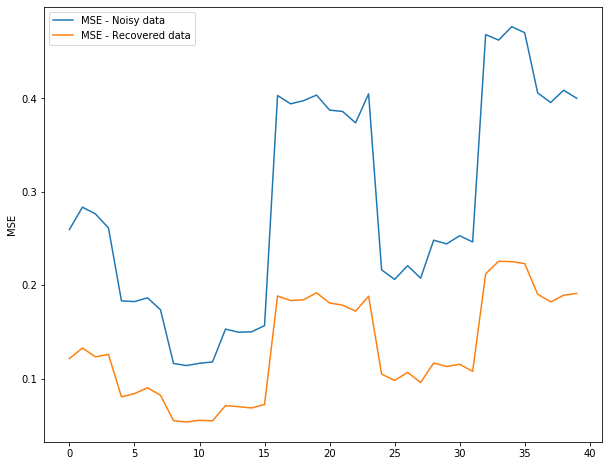

In [41]:
## Plotting the results (tentetive)
# complete this
fig = plt.figure(figsize=(10,8))
plt.plot(noisy_stat, label = 'MSE - Noisy data')
plt.plot(recovered_stat, label = 'MSE - Recovered data')
plt.ylabel('MSE')
plt.legend()

##RESULT

**We can see the Recovered Data has a lower MSE(Mean Squared Error ) than the Noisy Data. reduced almost by a margin of 0.2 approximately. Thus, we were successful in denoising the noisy data using a linear Kalman filter.**

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw6' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw6.zip" for homework6 in this structure:
```
Jordan_Michael_111134567_hw6
        |---Jordan_Michael_111134567_hw6.ipynb
        |---Jordan_Michael_111134567_hw6.py
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

# References
[1] J. Martinez, R. Hossain, J. Romero, and J. J. Little, “A simple yet effective baseline for 3d human pose
estimation,” in ICCV, 2017.

<!--Write your report here in markdown or html-->
